## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [3]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0,l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio,l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio,l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 0.0]
L1_EXP = [1e-2, 1e-4, 1e-8, 0.0]

In [9]:
import itertools

In [10]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 189us/step - loss: 198.6027 - acc: 0.2463 - val_loss: 41.1224 - val_acc: 0.2726
Epoch 2/50
50000/50000 [==============================] - 8s 165us/step - loss: 19.1235 - acc: 0.1207 - val_loss: 7.2843 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.1166 - acc: 0.0997 - val_loss: 2.6499 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 168us/step - loss: 2.4865 - acc: 0.0981 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.4626 - acc: 0.0958 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.4626 - acc: 0.0961 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 2.4626 - acc: 0.0990 - val_loss: 2.462

50000/50000 [==============================] - 9s 185us/step - loss: 198.6174 - acc: 0.2246 - val_loss: 41.1282 - val_acc: 0.2406
Epoch 2/50
50000/50000 [==============================] - 8s 165us/step - loss: 19.1254 - acc: 0.1172 - val_loss: 7.2873 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 166us/step - loss: 4.1081 - acc: 0.1000 - val_loss: 2.6475 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.4863 - acc: 0.0982 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 168us/step - loss: 2.4626 - acc: 0.0993 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.4626 - acc: 0.0965 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 8/50
50000/50000 [=================

50000/50000 [==============================] - 10s 192us/step - loss: 19.0560 - acc: 0.1160 - val_loss: 7.2550 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.1020 - acc: 0.0978 - val_loss: 2.6505 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4868 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.4626 - acc: 0.0984 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.4626 - acc: 0.0999 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/50
50000/50000 [===================

50000/50000 [==============================] - 10s 198us/step - loss: 13.9480 - acc: 0.3813 - val_loss: 12.9676 - val_acc: 0.3885
Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 12.1004 - acc: 0.3946 - val_loss: 11.2647 - val_acc: 0.3981
Epoch 5/50
50000/50000 [==============================] - 9s 188us/step - loss: 10.5299 - acc: 0.4054 - val_loss: 9.8242 - val_acc: 0.3999
Epoch 6/50
50000/50000 [==============================] - 8s 166us/step - loss: 9.1948 - acc: 0.4106 - val_loss: 8.5957 - val_acc: 0.4079
Epoch 7/50
50000/50000 [==============================] - 8s 164us/step - loss: 8.0564 - acc: 0.4176 - val_loss: 7.5420 - val_acc: 0.4221
Epoch 8/50
50000/50000 [==============================] - 9s 178us/step - loss: 7.0874 - acc: 0.4214 - val_loss: 6.6537 - val_acc: 0.4244
Epoch 9/50
50000/50000 [==============================] - 8s 167us/step - loss: 6.2623 - acc: 0.4249 - val_loss: 5.8886 - val_acc: 0.4290
Epoch 10/50
50000/50000 [==============

50000/50000 [==============================] - 8s 170us/step - loss: 5.5676 - acc: 0.4166 - val_loss: 5.5159 - val_acc: 0.4137
Epoch 5/50
50000/50000 [==============================] - 8s 166us/step - loss: 5.4524 - acc: 0.4323 - val_loss: 5.4167 - val_acc: 0.4251
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 5.3463 - acc: 0.4448 - val_loss: 5.3072 - val_acc: 0.4469
Epoch 7/50
50000/50000 [==============================] - 8s 167us/step - loss: 5.2465 - acc: 0.4586 - val_loss: 5.2161 - val_acc: 0.4507
Epoch 8/50
50000/50000 [==============================] - 8s 167us/step - loss: 5.1518 - acc: 0.4662 - val_loss: 5.1246 - val_acc: 0.4601
Epoch 9/50
50000/50000 [==============================] - 9s 184us/step - loss: 5.0597 - acc: 0.4743 - val_loss: 5.0318 - val_acc: 0.4690
Epoch 10/50
50000/50000 [==============================] - 9s 172us/step - loss: 4.9696 - acc: 0.4821 - val_loss: 4.9640 - val_acc: 0.4679
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 8s 167us/step - loss: 5.3480 - acc: 0.4316 - val_loss: 5.3037 - val_acc: 0.4341
Epoch 6/50
50000/50000 [==============================] - 9s 184us/step - loss: 5.2487 - acc: 0.4439 - val_loss: 5.2062 - val_acc: 0.4495
Epoch 7/50
50000/50000 [==============================] - 9s 172us/step - loss: 5.1560 - acc: 0.4568 - val_loss: 5.1230 - val_acc: 0.4539
Epoch 8/50
50000/50000 [==============================] - 8s 166us/step - loss: 5.0665 - acc: 0.4654 - val_loss: 5.0421 - val_acc: 0.4580
Epoch 9/50
50000/50000 [==============================] - 8s 166us/step - loss: 4.9799 - acc: 0.4737 - val_loss: 4.9600 - val_acc: 0.4618
Epoch 10/50
50000/50000 [==============================] - 8s 166us/step - loss: 4.8970 - acc: 0.4848 - val_loss: 4.8858 - val_acc: 0.4653
Epoch 11/50
50000/50000 [==============================] - 8s 166us/step - loss: 4.8166 - acc: 0.4889 - val_loss: 4.8162 - val_acc: 0.4734
Epoch 12/50
50000/50000 [==================

50000/50000 [==============================] - 7s 146us/step - loss: 5.2390 - acc: 0.4459 - val_loss: 5.2014 - val_acc: 0.4472
Epoch 7/50
50000/50000 [==============================] - 7s 146us/step - loss: 5.1454 - acc: 0.4569 - val_loss: 5.1245 - val_acc: 0.4517
Epoch 8/50
50000/50000 [==============================] - 7s 146us/step - loss: 5.0538 - acc: 0.4668 - val_loss: 5.0479 - val_acc: 0.4537
Epoch 9/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.9679 - acc: 0.4757 - val_loss: 4.9476 - val_acc: 0.4695
Epoch 10/50
50000/50000 [==============================] - 7s 148us/step - loss: 4.8842 - acc: 0.4827 - val_loss: 4.9035 - val_acc: 0.4610
Epoch 11/50
50000/50000 [==============================] - 7s 147us/step - loss: 4.8030 - acc: 0.4902 - val_loss: 4.7945 - val_acc: 0.4769
Epoch 12/50
50000/50000 [==============================] - 7s 144us/step - loss: 4.7211 - acc: 0.4986 - val_loss: 4.7269 - val_acc: 0.4797
Epoch 13/50
50000/50000 [=================

Epoch 7/50
50000/50000 [==============================] - 8s 167us/step - loss: 6.8323 - acc: 0.4228 - val_loss: 6.4410 - val_acc: 0.4243
Epoch 8/50
50000/50000 [==============================] - 8s 165us/step - loss: 6.0892 - acc: 0.4290 - val_loss: 5.7518 - val_acc: 0.4348
Epoch 9/50
50000/50000 [==============================] - 8s 167us/step - loss: 5.4542 - acc: 0.4337 - val_loss: 5.1675 - val_acc: 0.4367
Epoch 10/50
50000/50000 [==============================] - 8s 165us/step - loss: 4.9117 - acc: 0.4375 - val_loss: 4.6684 - val_acc: 0.4377
Epoch 11/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.4487 - acc: 0.4429 - val_loss: 4.2443 - val_acc: 0.4356
Epoch 12/50
50000/50000 [==============================] - 8s 168us/step - loss: 4.0523 - acc: 0.4444 - val_loss: 3.8871 - val_acc: 0.4405
Epoch 13/50
50000/50000 [==============================] - 8s 168us/step - loss: 3.7121 - acc: 0.4497 - val_loss: 3.5629 - val_acc: 0.4490
Epoch 14/50
50000/50000 [=====

50000/50000 [==============================] - 8s 167us/step - loss: 1.6639 - acc: 0.4663 - val_loss: 1.6660 - val_acc: 0.4630
Epoch 9/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.6362 - acc: 0.4742 - val_loss: 1.6596 - val_acc: 0.4647
Epoch 10/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.6109 - acc: 0.4818 - val_loss: 1.6339 - val_acc: 0.4715
Epoch 11/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.5851 - acc: 0.4905 - val_loss: 1.6103 - val_acc: 0.4764
Epoch 12/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.5618 - acc: 0.5009 - val_loss: 1.5957 - val_acc: 0.4861
Epoch 13/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5395 - acc: 0.5071 - val_loss: 1.6050 - val_acc: 0.4818
Epoch 14/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.5178 - acc: 0.5138 - val_loss: 1.5728 - val_acc: 0.4916
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 9s 183us/step - loss: 1.4943 - acc: 0.4749 - val_loss: 1.5051 - val_acc: 0.4679
Epoch 10/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4677 - acc: 0.4837 - val_loss: 1.5067 - val_acc: 0.4652
Epoch 11/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.4438 - acc: 0.4942 - val_loss: 1.4763 - val_acc: 0.4774
Epoch 12/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.4224 - acc: 0.5005 - val_loss: 1.4525 - val_acc: 0.4839
Epoch 13/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.3995 - acc: 0.5087 - val_loss: 1.4455 - val_acc: 0.4833
Epoch 14/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3795 - acc: 0.5148 - val_loss: 1.4674 - val_acc: 0.4820
Epoch 15/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.3602 - acc: 0.5213 - val_loss: 1.4409 - val_acc: 0.4909
Epoch 16/50
50000/50000 [==============

50000/50000 [==============================] - 7s 148us/step - loss: 1.4668 - acc: 0.4863 - val_loss: 1.4847 - val_acc: 0.4709
Epoch 11/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.4413 - acc: 0.4956 - val_loss: 1.4696 - val_acc: 0.4760
Epoch 12/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.4187 - acc: 0.5033 - val_loss: 1.4632 - val_acc: 0.4805
Epoch 13/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.3980 - acc: 0.5093 - val_loss: 1.4408 - val_acc: 0.4864
Epoch 14/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.3780 - acc: 0.5174 - val_loss: 1.4298 - val_acc: 0.4900
Epoch 15/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.3578 - acc: 0.5202 - val_loss: 1.4228 - val_acc: 0.4916
Epoch 16/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.3394 - acc: 0.5294 - val_loss: 1.4318 - val_acc: 0.4944
Epoch 17/50
50000/50000 [==============

50000/50000 [==============================] - 8s 160us/step - loss: 4.4437 - acc: 0.4407 - val_loss: 4.2518 - val_acc: 0.4323
Epoch 12/50
50000/50000 [==============================] - 8s 160us/step - loss: 4.0468 - acc: 0.4434 - val_loss: 3.8707 - val_acc: 0.4441
Epoch 13/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.7070 - acc: 0.4469 - val_loss: 3.5653 - val_acc: 0.4372
Epoch 14/50
50000/50000 [==============================] - 7s 144us/step - loss: 3.4157 - acc: 0.4527 - val_loss: 3.2988 - val_acc: 0.4495
Epoch 15/50
50000/50000 [==============================] - 7s 149us/step - loss: 3.1661 - acc: 0.4566 - val_loss: 3.0703 - val_acc: 0.4490
Epoch 16/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.9523 - acc: 0.4582 - val_loss: 2.8642 - val_acc: 0.4543
Epoch 17/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.7692 - acc: 0.4628 - val_loss: 2.7244 - val_acc: 0.4469
Epoch 18/50
50000/50000 [==============

50000/50000 [==============================] - 7s 143us/step - loss: 1.5546 - acc: 0.5052 - val_loss: 1.5914 - val_acc: 0.4857
Epoch 13/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.5325 - acc: 0.5130 - val_loss: 1.5781 - val_acc: 0.4910
Epoch 14/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.5135 - acc: 0.5188 - val_loss: 1.5713 - val_acc: 0.4955
Epoch 15/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.4933 - acc: 0.5242 - val_loss: 1.5479 - val_acc: 0.4974
Epoch 16/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.4728 - acc: 0.5325 - val_loss: 1.5300 - val_acc: 0.5054
Epoch 17/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.4562 - acc: 0.5374 - val_loss: 1.5453 - val_acc: 0.5016
Epoch 18/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.4396 - acc: 0.5445 - val_loss: 1.5270 - val_acc: 0.5010
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 7s 139us/step - loss: 1.3989 - acc: 0.5094 - val_loss: 1.4393 - val_acc: 0.4896
Epoch 14/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.3783 - acc: 0.5158 - val_loss: 1.4447 - val_acc: 0.4890
Epoch 15/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.3585 - acc: 0.5239 - val_loss: 1.4260 - val_acc: 0.4880
Epoch 16/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.3397 - acc: 0.5267 - val_loss: 1.4788 - val_acc: 0.4718
Epoch 17/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.3227 - acc: 0.5362 - val_loss: 1.3968 - val_acc: 0.5015
Epoch 18/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.3049 - acc: 0.5408 - val_loss: 1.4273 - val_acc: 0.4891
Epoch 19/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.2886 - acc: 0.5455 - val_loss: 1.3858 - val_acc: 0.5015
Epoch 20/50
50000/50000 [==============

50000/50000 [==============================] - 6s 114us/step - loss: 1.3613 - acc: 0.5227 - val_loss: 1.4305 - val_acc: 0.4933
Epoch 15/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.3422 - acc: 0.5296 - val_loss: 1.4150 - val_acc: 0.4983
Epoch 16/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.3228 - acc: 0.5370 - val_loss: 1.4139 - val_acc: 0.4983
Epoch 17/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.3074 - acc: 0.5412 - val_loss: 1.3976 - val_acc: 0.4995
Epoch 18/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2883 - acc: 0.5475 - val_loss: 1.3867 - val_acc: 0.5069
Epoch 19/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.2711 - acc: 0.5533 - val_loss: 1.3725 - val_acc: 0.5138
Epoch 20/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.2567 - acc: 0.5601 - val_loss: 1.3774 - val_acc: 0.5094ss: 1.2566 - a
Epoch 21/50
50000/50000 [

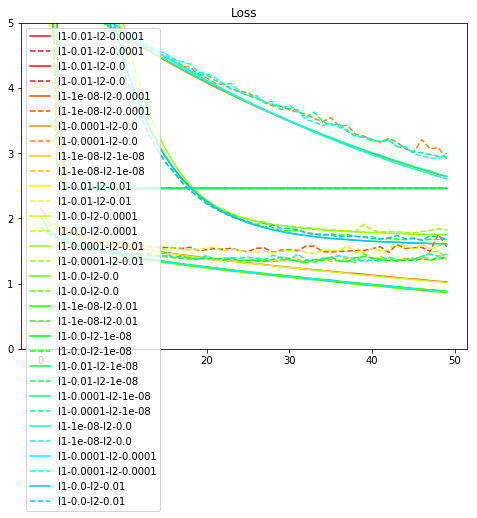

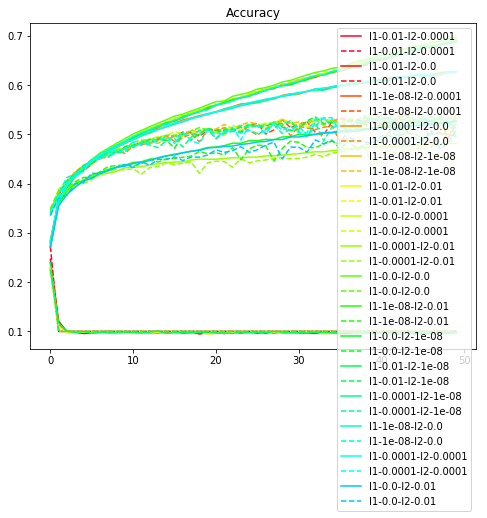

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果